# Natural Language Processing with Disaster Tweets

This Jupyter notebook is stored here: https://github.com/jaworXYZ/5511-Disaster-Tweets-NLP-/blob/main/M4-DisasterTweets.ipynb, and corresponds to the following Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/overview.

The challenge presented in this competition is to distinguish between tweets about real disasters and ones that aren't (but might include keywords that more frequently correspond to real diasters.

Submissions to this challenge are predictions on a test dataset which are evaluated on F1 score.

* [Exploratory Data Analysis (EDA)](#eda)
   * [Tweet Text EDA](#eda-tweet)
   * [Additional CSV Files](#eda-csv)
* [Cleaning & Data Prep](#prep)
* [Models - Strategy 1](#model)
   * [A Non-Recurrent Model](#pool)
   * [Single-Layer GRU models](#gru)
   * [Single-Layer GRU models with Regularization](#gru_r)
   * [Bidirectional GRU models](#bgru)
   * [Two-Layer GRU models](#2gru)
   * [Single-Layer LSTM models](#lstm)
   * [Two-Layer LSTM models](#2lstm)
   * [Bidirectional LSTM models](#blstm)
* [Models - Strategy 2](#model2)
   * [Low-Unit Recurrent Models](#small)
   * [Low-Unit Recurrent Models with Regularization](#small_r)
   * [Low-Unit Recurrent Models with Strong Regularization](#small_rr)
* [Summary of Results](#results)
* [Conclusion](#conclusion)
* [References](#references)



### Libraries Import

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, \
                                    GRU, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout
from keras import backend as K

np.random.seed(7)
tf.random.set_seed(7)

sns.set_theme()
# Make tweets easier to read:
pd.set_option('display.max_colwidth', 150)

## Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a>

Three csv files are available: *train.csv, test.csv,* and *sample_submission.csv*. The following description of the data is provided:
 - **id** - a unique identifier for each tweet
 - **text** - the text of the tweet
 - **location** - the location the tweet was sent from (may be blank)
 - **keyword** - a particular keyword from the tweet (may be blank)
 - **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [2]:
df = pd.read_csv('nlp-getting-started/train.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


> As described, we have blank/Nan values for keyword and location for at least some of our tweets.

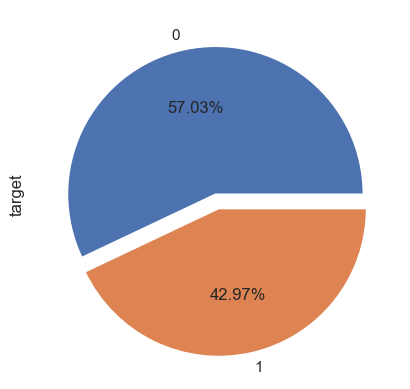

In [4]:
# Check distribution of classes
df.target.value_counts().plot.pie(explode=[0,0.1], autopct='%.2f%%')
plt.show()

In [5]:
df.shape

(7613, 5)

In [6]:
print(f'There are {df.keyword.nunique()} unique keywords, the first five of which are: \
{", ".join(list(df.keyword.unique()[1:6]))}')

print(f'\nThere are {df.location.nunique()} unique locations, the first five of which are: \
{", ".join(list(df.location.unique()[1:6]))}')

There are 221 unique keywords, the first five of which are: ablaze, accident, aftershock, airplane%20accident, ambulance

There are 3341 unique locations, the first five of which are: Birmingham, Est. September 2012 - Bristol, AFRICA, Philadelphia, PA, London, UK


> Given we have 3341 locations in our dataset of 7613 tweets, it is unlikely that *most* locations will be at all useful.

In [7]:
df.location.isna().sum()

2533

In [8]:
df.keyword.isna().sum()

61

In [9]:
loc_count = df.location.value_counts()
loc_count

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [10]:
loc_count_hi = loc_count[loc_count>5]
loc_count_hi

USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
                                 ... 
Brooklyn, NY                        6
 Road to the Billionaires Club      6
Singapore                           6
Pedophile hunting ground            6
Calgary, Alberta                    6
Name: location, Length: 76, dtype: int64

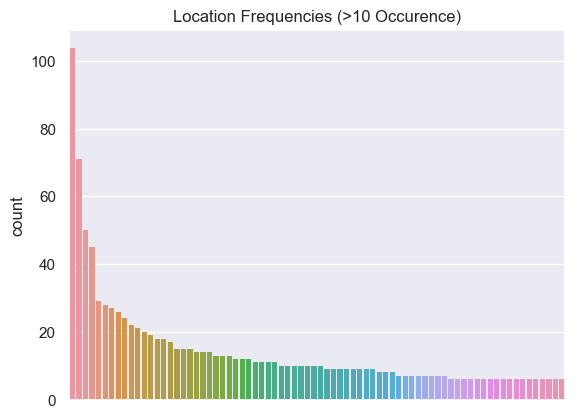

In [11]:
sns.barplot(x=loc_count_hi.index, y=loc_count_hi.values, linewidth=0)
plt.xticks([])
plt.title('Location Frequencies (>10 Occurence)')
plt.ylabel('count')
plt.show()

In [12]:
kw_count = df.keyword.value_counts()
kw_count

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

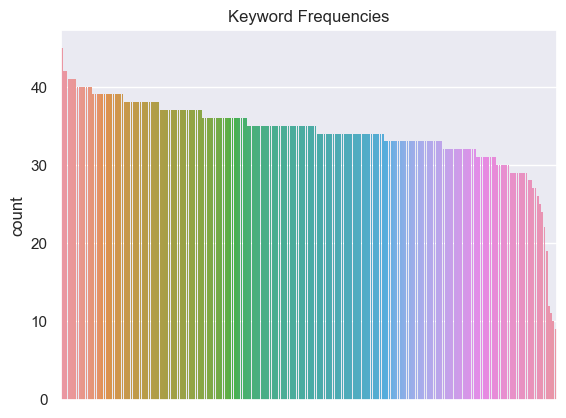

In [13]:
sns.barplot(x=kw_count.index, y=kw_count.values, linewidth=0)
plt.xticks([])
plt.title('Keyword Frequencies')
plt.ylabel('count')
plt.show()

In [14]:
df[df.keyword.isna()==False][["keyword","text"]].sample(10, random_state=7)

,keyword,text
5562,rainstorm,Landslide in Italian Alps kills three: ROME (Reuters) - Three people were killed when a severe rainstorm in th... http://t.co/SmKZnF52Za
6345,structural%20failure,Investigators have said a Virgin Galactic spaceship crash was caused by structural failure after the co-pilot ... http://t.co/WC69XAJIs4
6516,survive,In a dream you saw a way to survive and you were full of joy.
1088,bomb,The hatchet-wielding gunman had PEPPER SPRAY AND A FAKE BOMB?!?!?
6936,trouble,@charlieputh that song have a Cool beat like Nothing But Trouble
5815,rubble,My parents are so impulsive sometimes. I remember coming home to my room filled with dust &amp; rubble just because they wanted it redesigned. ??
1820,crashed,@_rosewell it has crashed so many times the past couple hours
761,blew%20up,Just realized my dude @_OnlyFTF was on that 'What Are Those' way before it blew up @ the tusky ?? game @robsimss @CantMissKid
3706,fear,The things we fear most in organizations--fluctuations disturbances imbalances--are the primary sources of creativity. - Margaret Wheatley
2381,derail,Lake Dallas crash causes train to derail http://t.co/ao4Ju9vMMF


> As expected, keywords are present in the tweets themselves.

Keyword could be a useful way to highlight the specific vocabulary related to disasters.



### Tweet Text EDA<a class="anchor" id="eda-tweet"></a>

From the previous samples, we can identify:
 - tweets containing @names
 - tweets containing links
 - capitalization and special characters

In [15]:
def wordcnt(text):
    return text.count(" ")+1

word_counts = df.text.map(lambda text: wordcnt(text))
word_counts

0       13
1        7
2       22
3        9
4       17
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: text, Length: 7613, dtype: int64

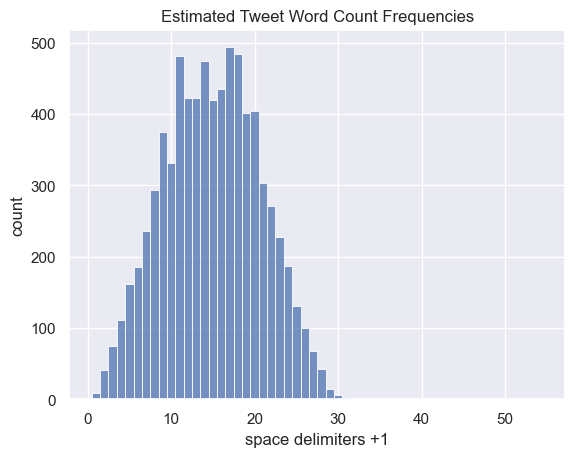

In [16]:
sns.histplot(word_counts, discrete=True)
plt.title('Estimated Tweet Word Count Frequencies')
plt.ylabel('count')
plt.xlabel('space delimiters +1')
plt.show()

> Given Twitter's (former) 140-character limit, a max length of 30 or so words seems reasonable (4-5 letter average sounds realistic). There appears to be an outlier challenging this assumption/understanding. So let's investigate...

In [17]:
word_counts[word_counts>35].count()

1

In [18]:
df.iloc[word_counts.idxmax()].text

'Rescuers recover body of 37-year-old Calgary man from lake near Vulcan \n                            \n             \x89Û_ http://t.co/gAEhr9bHEk'

> We can see that the single outlier is the product of extra spacing. This won't cause any issues with our data preparation, so it can be ignored.

### Additional CSV Files <a class="anchor" id="eda-csv"></a>

In [19]:
tsdf = pd.read_csv('nlp-getting-started/test.csv')
tsdf

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


> This follows the same format as train.csv, less the *target* column. The test set contains 3263 rows.

In [20]:
submdf = pd.read_csv('nlp-getting-started/sample_submission.csv')
submdf

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


> The submission should include *id* and *target* columns.

## Cleaning & Data Prep <a class="anchor" id="prep"></a>
Cleaning:
- Remove @mentions 
- Remove links (http:// or www.)
- Replace Nan values with space (will be ignored in tokenization)
- Remove punctuation *through TextVectorization()*
- Remove capitalization *through TextVectorization()*

Prep:
- Create

In [21]:
def tweetscleaner(df):
    '''
    df: pandas dataframe to transform
    cleans dataframe in-place
    '''
    # replace the NaN values with a space, so they will be ignored
    df.fillna(' ', inplace=True)
    #print(df)
    
    def singlecleaner(tweet):
        # remove links beginning with "http://" or "www.", remove @mentions
        return re.compile(r'https?://\S+|www\.\S+|@\S+').sub(r'',tweet)
    
    df.text = df.text.apply(lambda twt: singlecleaner(twt))

In [22]:
#clean 
tweetscleaner(df)
tweetscleaner(tsdf)

In [23]:
trdf, vldf = train_test_split(df, test_size=0.1, random_state=7, stratify=df.target)
trdf.shape, vldf.shape

((6851, 5), (762, 5))

In [24]:
def get_numpy(col_names):
    ''' 
    converts df to feature and target numpy arrays 
    col_names: list of df column names to include in target
    outputs dictionary of numpy arrays
    '''
    numpy_dict = {}
    numpy_dict['trx'] = np.array(trdf[col_names])
    numpy_dict['try'] = np.array(trdf['target'])
    numpy_dict['vlx'] = np.array(vldf[col_names])
    numpy_dict['vly'] = np.array(vldf['target'])
    numpy_dict['tsx'] = np.array(tsdf[col_names])
    
    return numpy_dict

## Modeling<a class="anchor" id="model"></a>

To start, we will begin by converting the text of the tweets to vectors. We will discard the location and keyword columns for now.

In [25]:
# Using only tweet text
nmp = get_numpy(['text'])

In [26]:
max_tokens = 10000
max_len = 35 # we established that we don't have more words/tokens than this in the training tweets

Vector_layer = TextVectorization(max_tokens=max_tokens,
                            standardize='lower_and_strip_punctuation', # completes the cleaning
                            output_mode='int',
                            output_sequence_length=max_len)

Vector_layer.adapt(nmp['trx']) # train on our new set

In [27]:
# get f1_score metric
# from https://saturncloud.io/blog/keras-f1-score-metrics-a-comprehensive-guide-for-training-your-model/

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [28]:
# set up callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5, 
                                            verbose=1, mode="max",
                                            restore_best_weights=True)

# function to compile, fit, and plot metrics
# returns history object and data frame version of results
def runplot(model_obj):
    # COMPILE
    model_obj.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',f1_score])
    
    # FIT
    hist_obj = model_obj.fit(x=nmp['trx'], y=nmp['try'], 
                             validation_data=(nmp['vlx'],nmp['vly']), 
                             epochs=50, # limit if callback isn't reached
                             callbacks=[callback],
                             verbose=0)

    # PUT RESULTS IN DATAFRAME
    hist_df = pd.DataFrame(hist_obj.history)
    hist_df.index+=1 # so index matches batch number
    best_batch = hist_df.val_f1_score.idxmax()
    
    # PLOT METRICS
    f, axes = plt.subplots(1, 3, figsize=(9,3))
    sns.lineplot({"Training":hist_df['loss'],
                  "Validation":hist_df['val_loss']}, 
                  ax=axes[0], palette=['b', 'r'], dashes=False).set(
                    title = "Loss vs Epoch", xlim=(0,None), ylim=(0,None))
    sns.lineplot({"Training":hist_df['accuracy'],
                  "Validation":hist_df['val_accuracy']}, 
                  ax=axes[1], palette=['b', 'r'], dashes=False).set(
                    title = "Accuracy vs Epoch", xlim=(0,None), ylim=(0,1))
    sns.lineplot({"Training":hist_df['f1_score'],
                  "Validation":hist_df['val_f1_score']}, 
                  ax=axes[2], palette=['b', 'r'], dashes=False).set(
                    title = "F1 Score vs Epoch", xlim=(0,None), ylim=(0,1))
    plt.show()   
    
    # PRINT METRICS FROM BEST BATCH
    print(f'Best validation F1 score (from Batch {best_batch})\
    was {hist_df.val_f1_score.loc[best_batch]}')
    print(f'All stats: \n{hist_df.loc[[best_batch]]}')
    
    return hist_obj, hist_df

#### p0: No LSTM (Global Pooling)<a class="anchor" id="pool"></a>
Begin with a simple model to hopefully improve upon with recurrent models.

Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


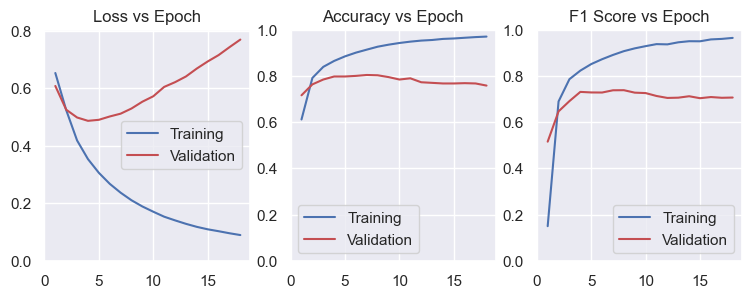

Best validation F1 score (from Batch 8)    was 0.7386094927787781
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
8  0.210329  0.926872  0.907558  0.529217       0.80315      0.738609


In [49]:
p0= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')])
hp0 = runplot(p0)

#### g1*: Single-Layer GRU Models<a class="anchor" id="gru"></a>

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


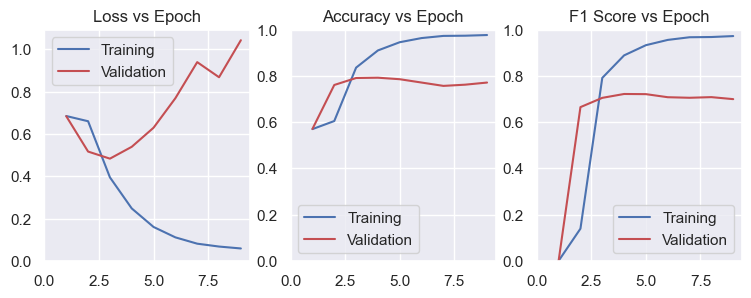

Best validation F1 score (from Batch 4)    was 0.7221773266792297
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.24766   0.91067  0.889248  0.539093      0.792651      0.722177


In [102]:
g1= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1 = runplot(g1)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


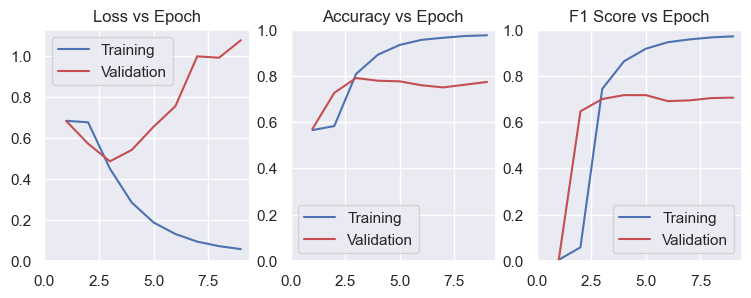

Best validation F1 score (from Batch 4)    was 0.7172486186027527
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.285165  0.892278  0.864056  0.542459      0.779528      0.717249


In [48]:
g1_= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32),
    Dense(1, activation='sigmoid')])
hg1_ = runplot(g1_)

> Check if Dense layer should be larger

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


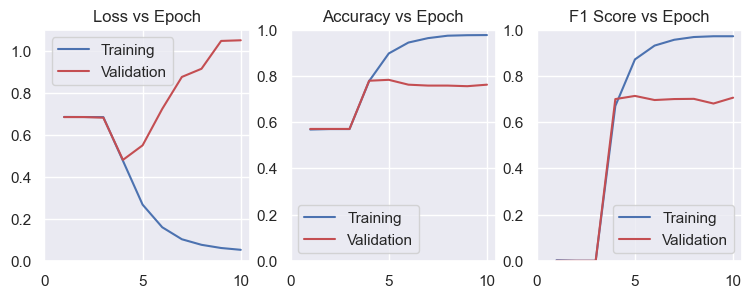

Best validation F1 score (from Batch 5)    was 0.7137651443481445
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.267184  0.897679  0.871875  0.549419      0.783465      0.713765


In [103]:
g1b= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32),
    Dense((64), activation='relu'),
    Dense(1, activation='sigmoid')])
hg1b = runplot(g1b)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


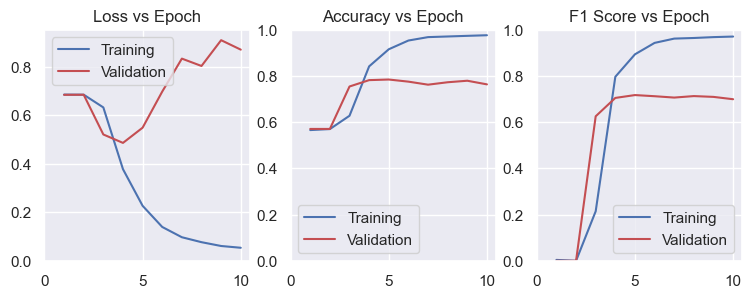

Best validation F1 score (from Batch 5)    was 0.7174649238586426
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.226607  0.915779  0.893844  0.548327      0.784777      0.717465


In [104]:
g1c= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1c = runplot(g1c)

Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping


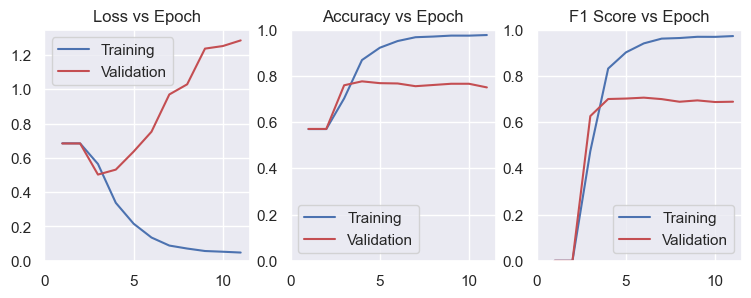

Best validation F1 score (from Batch 6)    was 0.7062990665435791
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
6  0.135665  0.951394  0.941255  0.752184      0.767717      0.706299


In [107]:
g1_64= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1_64 = runplot(g1_64)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


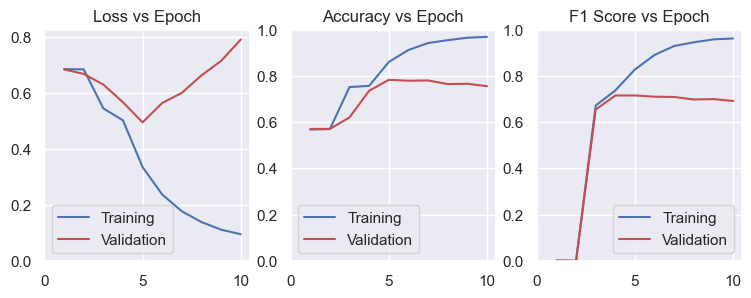

Best validation F1 score (from Batch 5)    was 0.7156813144683838
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.334701  0.860604  0.828343  0.494555      0.783465      0.715681


In [49]:
g1_64_= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64),
    Dense(1, activation='sigmoid')])
hg1_64_ = runplot(g1_64_)

#### g1x*: Single-Layer GRU with Regularization <a class="anchor" id="gru_r"></a>
Given the lack of visible improvement with further training, regularization seems necessary

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


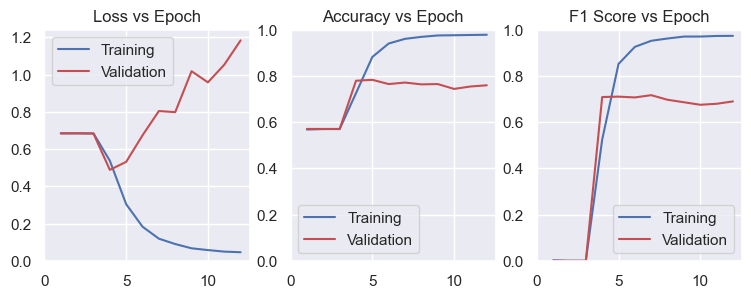

Best validation F1 score (from Batch 7)    was 0.7170367240905762
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
7  0.118775  0.960882  0.952446  0.803916      0.771654      0.717037


In [105]:
g1d= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, dropout=0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1d = runplot(g1d)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


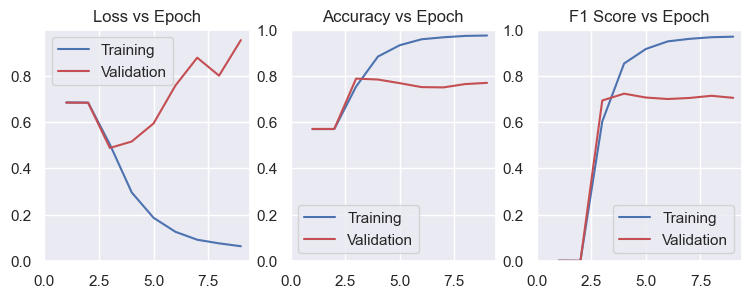

Best validation F1 score (from Batch 4)    was 0.7235538959503174
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.295354  0.884104  0.854087  0.515685      0.784777      0.723554


In [109]:
g1sd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    SpatialDropout1D(0.1),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1sd = runplot(g1sd)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


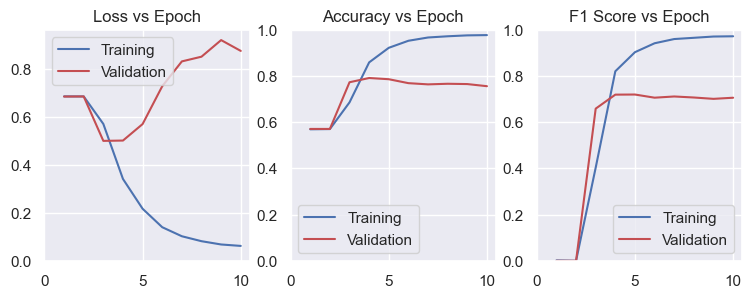

Best validation F1 score (from Batch 5)    was 0.7198195457458496
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.216678  0.922055  0.903123  0.569277      0.786089       0.71982


In [110]:
g1sd2= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    SpatialDropout1D(0.2),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1sd2 = runplot(g1sd2)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


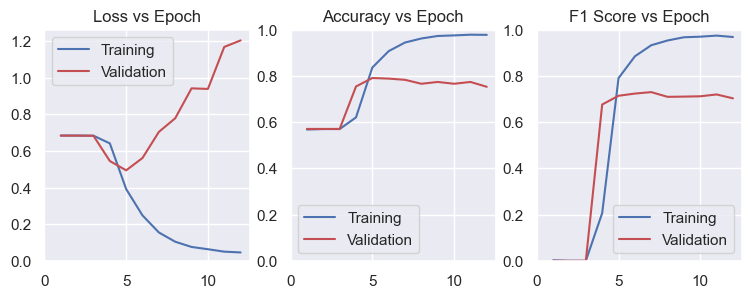

Best validation F1 score (from Batch 7)    was 0.7302528023719788
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
7  0.15487  0.944972  0.933125  0.704326      0.783465      0.730253


In [106]:
g1rd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, recurrent_dropout=0.1),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1rd = runplot(g1rd)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


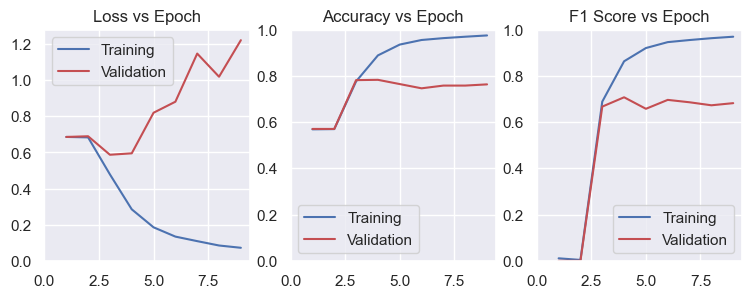

Best validation F1 score (from Batch 4)    was 0.7078755497932434
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.285225  0.889213  0.863761  0.595416      0.783465      0.707876


In [67]:
g1rd2= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1rd2 = runplot(g1rd2)

Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping


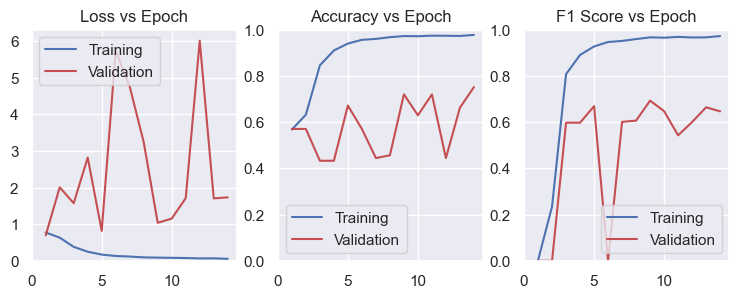

Best validation F1 score (from Batch 9)    was 0.6933553218841553
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
9  0.086591  0.972851  0.967269   1.03778      0.720472      0.693355


In [66]:
g1rr= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, recurrent_regularizer='l2'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1rr = runplot(g1rr)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


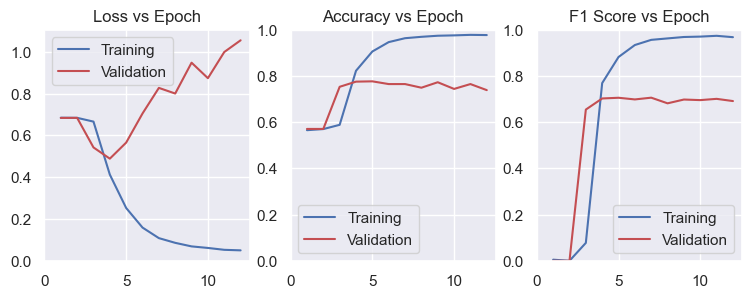

Best validation F1 score (from Batch 7)    was 0.7061910629272461
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
7  0.108549  0.963655  0.956485  0.827571      0.765092      0.706191


In [111]:
g1sdrd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    SpatialDropout1D(0.1),
    GRU(32, recurrent_dropout=0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1sdrd = runplot(g1sdrd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


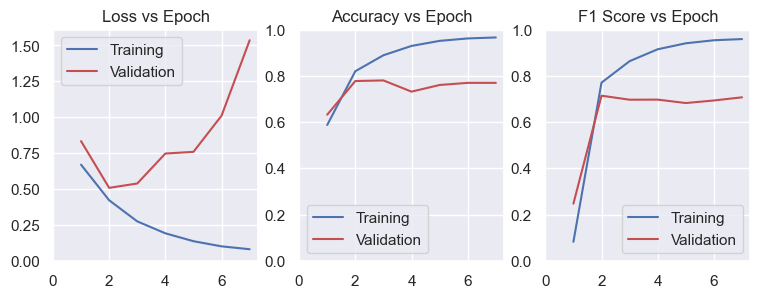

Best validation F1 score (from Batch 2)    was 0.7148072719573975
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.421811  0.820756  0.771329  0.508157      0.778215      0.714807


In [68]:
g1_64= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1_64 = runplot(g1_64)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


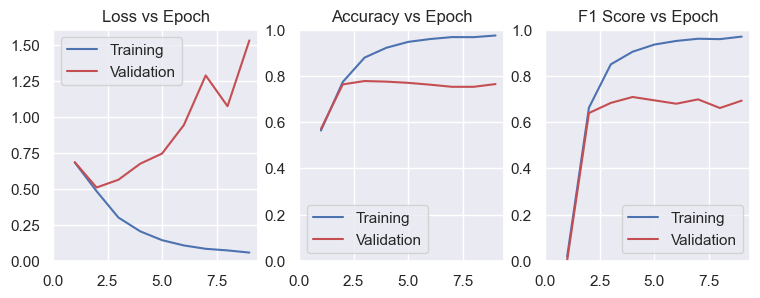

Best validation F1 score (from Batch 4)    was 0.7091894149780273
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.205063  0.922347  0.905131  0.676103      0.775591      0.709189


In [70]:
g1rd_64= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, recurrent_dropout=0.1),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg1rd_64 = runplot(g1rd_64)

#### g2*: Two-Layer GRU Models<a class="anchor" id="2gru"></a>

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


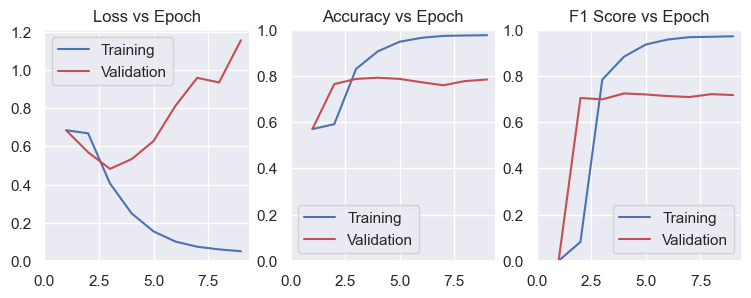

Best validation F1 score (from Batch 4)    was 0.7245214581489563
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.248012  0.907021  0.884071  0.533622      0.792651      0.724521


In [30]:
g2_32 = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, return_sequences=True),
    GRU(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_32 = runplot(g2_32)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


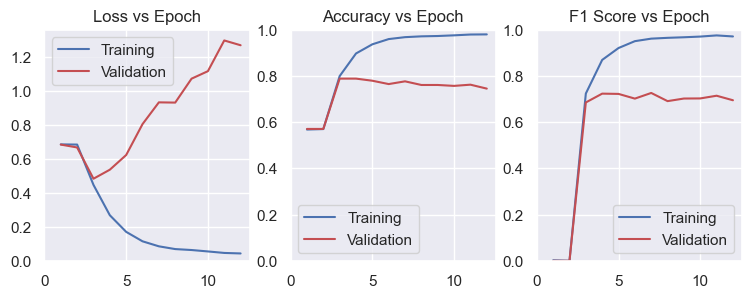

Best validation F1 score (from Batch 7)    was 0.7266187071800232
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
7  0.085225   0.96818  0.961735  0.932216      0.776903      0.726619


In [31]:
g2_32a = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(32, return_sequences=True),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_32a = runplot(g2_32a)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


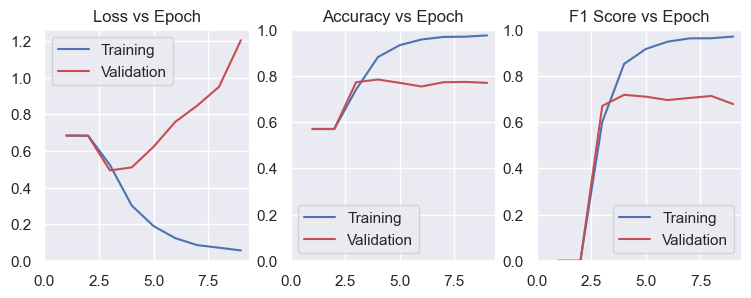

Best validation F1 score (from Batch 4)    was 0.71852707862854
All stats: 
     loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.3022  0.881915  0.852437  0.510354      0.784777      0.718527


In [33]:
g2_64 = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64 = runplot(g2_64)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


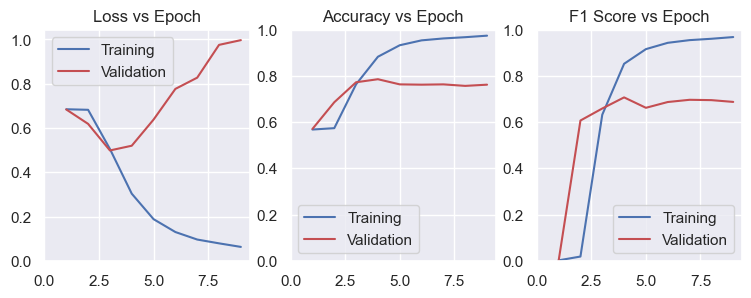

Best validation F1 score (from Batch 4)    was 0.7074377536773682
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.303401  0.883375  0.852881  0.519996      0.786089      0.707438


In [32]:
g2_64a = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64a = runplot(g2_64a)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


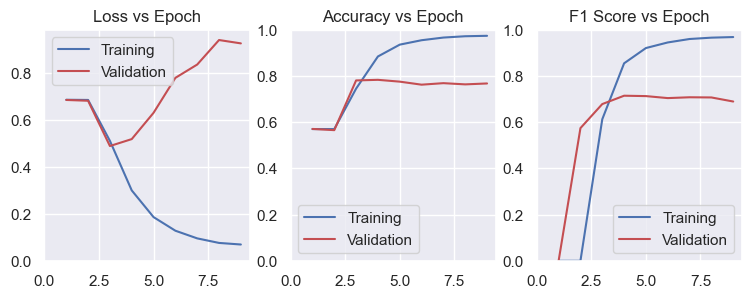

Best validation F1 score (from Batch 4)    was 0.7146654725074768
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.29943  0.884542  0.854931  0.517626      0.783465      0.714665


In [35]:
g2_64b = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64b = runplot(g2_64b)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


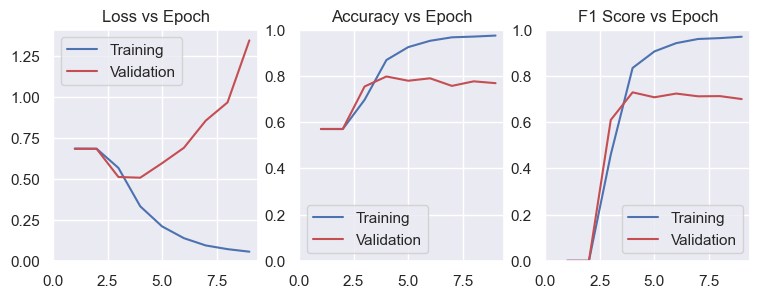

Best validation F1 score (from Batch 4)    was 0.7292678356170654
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.332704  0.869216  0.834838  0.507296        0.7979      0.729268


In [34]:
g2_64c = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64c = runplot(g2_64c)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


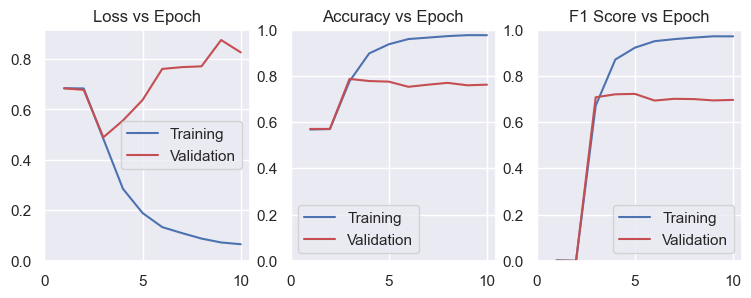

Best validation F1 score (from Batch 5)    was 0.7225673198699951
All stats: 
     loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.1894  0.937381  0.922727  0.637679      0.775591      0.722567


In [54]:
g2_64_ = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(8, return_sequences=True),
    GRU(8),
    Dense(1, activation='sigmoid')])
hg2_64_ = runplot(g2_64_)

#### g2x*: Two-Layer GRU Models with Regularization <a class="anchor" id="2gru_r"></a>

Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping


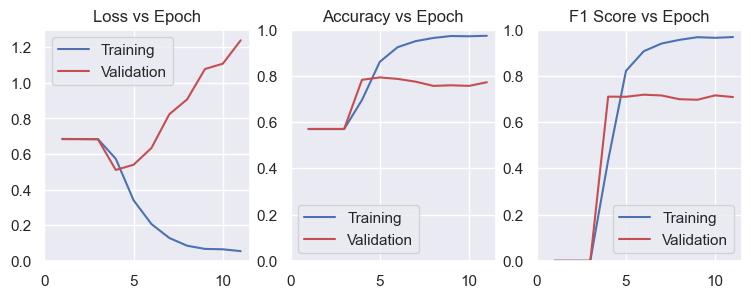

Best validation F1 score (from Batch 6)    was 0.719111979007721
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
6  0.206279  0.924828  0.907562  0.634254      0.787402      0.719112


In [36]:
g2_64rd = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True, recurrent_dropout=0.1),
    GRU(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64rd = runplot(g2_64rd)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


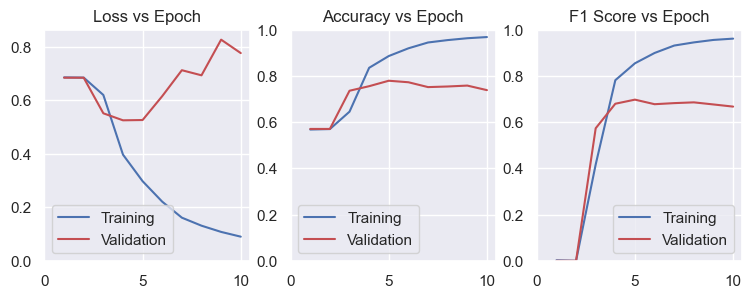

Best validation F1 score (from Batch 5)    was 0.6977090239524841
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.297316   0.88644  0.855059  0.525759      0.779528      0.697709


In [37]:
g2_64d = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    GRU(64, return_sequences=True, dropout=0.1),
    GRU(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])
hg2_64d = runplot(g2_64d)

#### bg1*: Bidirectional GRU models<a class="anchor" id="bgru"></a>

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


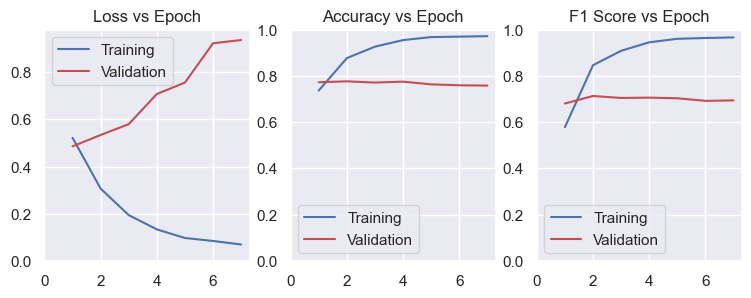

Best validation F1 score (from Batch 2)    was 0.7135195136070251
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.306088   0.87739  0.846762   0.53375      0.776903       0.71352


In [40]:
bg1= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(32)),
    Dense(32),
    Dense(1, activation='sigmoid')])
bg1 = runplot(bg1)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


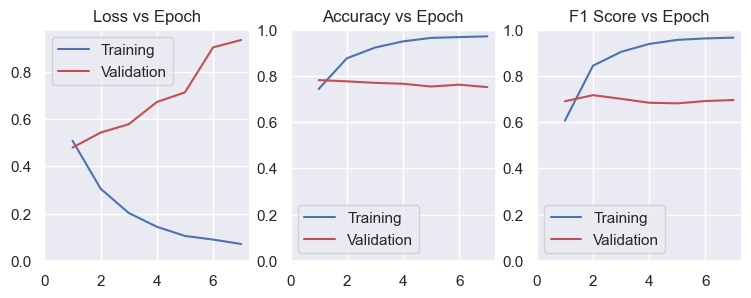

Best validation F1 score (from Batch 2)    was 0.7170822024345398
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.305701  0.876514  0.844649  0.543784      0.776903      0.717082


In [41]:
bg1a= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(64)),
    Dense(32),
    Dense(1, activation='sigmoid')])
bg1a = runplot(bg1a)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


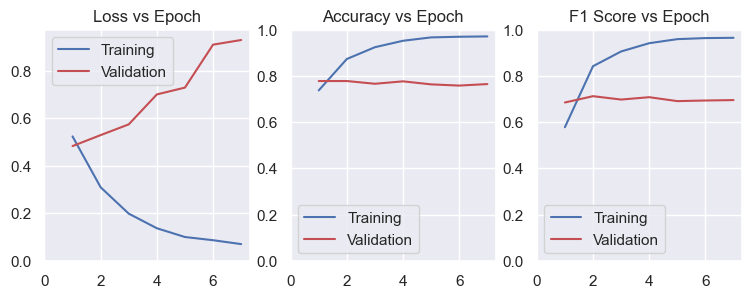

Best validation F1 score (from Batch 2)    was 0.7126620411872864
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.30964  0.873595  0.842403  0.529448      0.778215      0.712662


In [42]:
bg1b= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(32)),
    Dense(64),
    Dense(1, activation='sigmoid')])
bg1b = runplot(bg1b)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


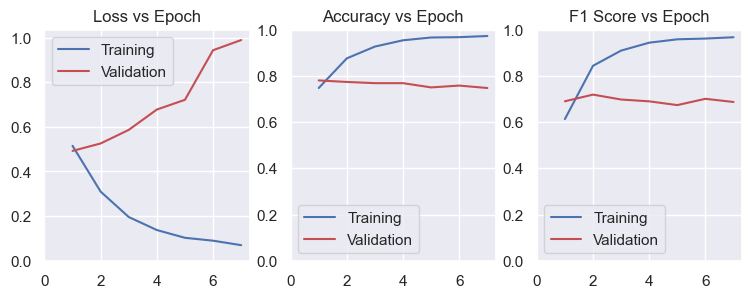

Best validation F1 score (from Batch 2)    was 0.7194817066192627
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.309848  0.876514  0.844234  0.525587      0.774278      0.719482


In [43]:
bg1c= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(128)),
    Dense(32),
    Dense(1, activation='sigmoid')])
hbg1c = runplot(bg1c)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


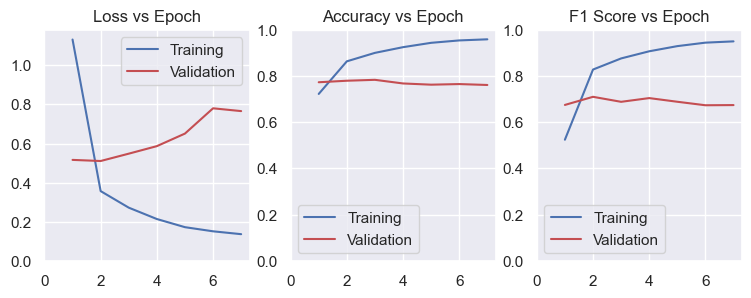

Best validation F1 score (from Batch 2)    was 0.7099207043647766
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.356637  0.863524  0.827943   0.51059      0.779528      0.709921


In [46]:
bg1krdrd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(64, kernel_regularizer='l2', dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbg1krdrd = runplot(bg1krdrd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


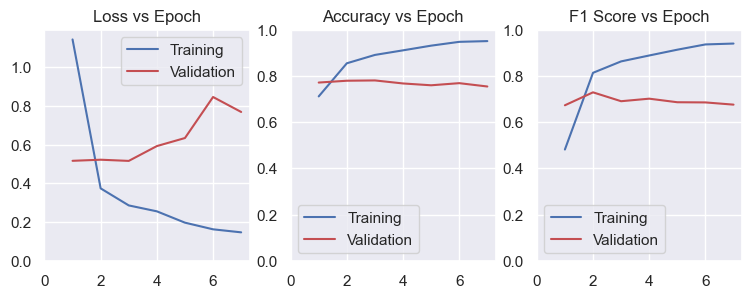

Best validation F1 score (from Batch 2)    was 0.7292983531951904
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.374225  0.855058  0.813793  0.522271      0.779528      0.729298


In [45]:
bg1krdrd_= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(GRU(64, kernel_regularizer='l2', dropout=0.3, recurrent_dropout=0.3)),
    #Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbg1krdrd_ = runplot(bg1krdrd_)

#### m1*: Single-Layer LSTM<a class="anchor" id="lstm"></a>

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


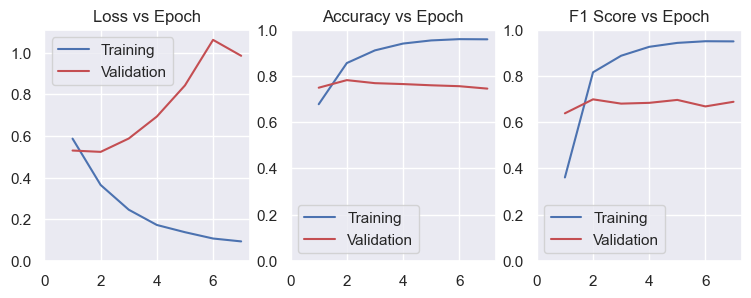

Best validation F1 score (from Batch 2)    was 0.6989691257476807
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.36436  0.856079  0.815948  0.523421      0.782152      0.698969


In [76]:
m1a= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
hm1a = runplot(m1a)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


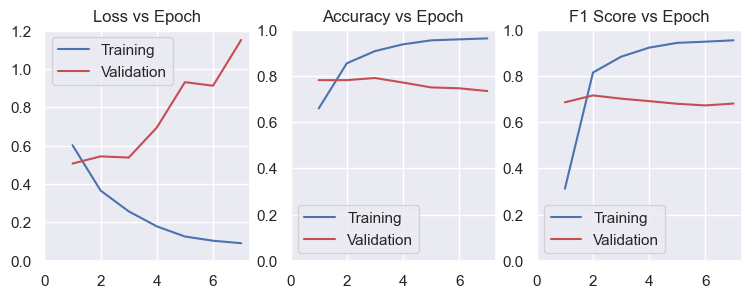

Best validation F1 score (from Batch 2)    was 0.7158815264701843
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.366196  0.855058  0.815086  0.544813      0.782152      0.715882


In [71]:
m1b= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hm1b = runplot(m1b)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


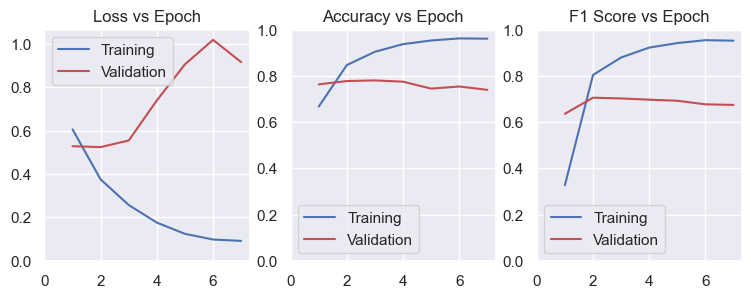

Best validation F1 score (from Batch 2)    was 0.7061417102813721
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.375334  0.847322  0.804541  0.524693      0.778215      0.706142


In [77]:
m1c= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])
hm1c = runplot(m1c)

#### m1x*: Single-Layer LSTM with Regularization<a class="anchor" id="lstm_r"></a>

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


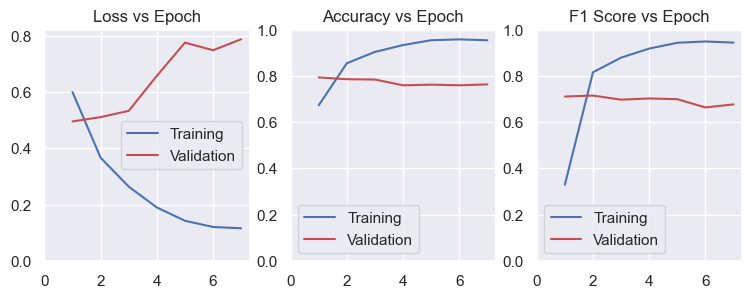

Best validation F1 score (from Batch 2)    was 0.7153746485710144
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.366482  0.855204  0.816355  0.511117      0.786089      0.715375


In [72]:
m1rd= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(32, recurrent_dropout=0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1rd = runplot(m1rd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


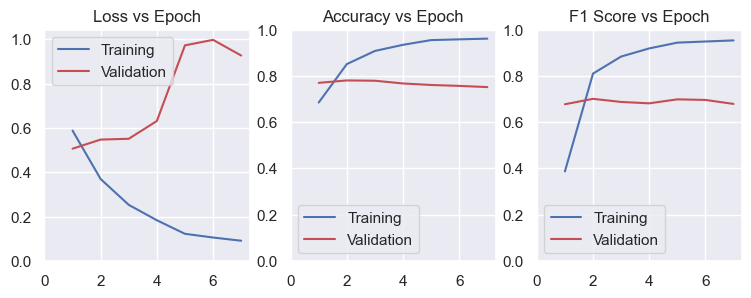

Best validation F1 score (from Batch 2)    was 0.7011494636535645
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.369187  0.851555  0.810422  0.547333       0.78084      0.701149


In [73]:
m1d= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(32, dropout=0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1d = runplot(m1d)

Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


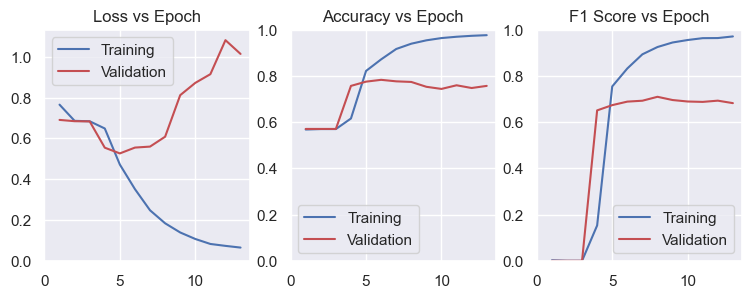

Best validation F1 score (from Batch 8)    was 0.7099869847297668
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
8  0.183816  0.939863  0.925449  0.608006      0.774278      0.709987


In [75]:
m1rr= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(32,  recurrent_regularizer='l2'),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1rr = runplot(m1rr)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


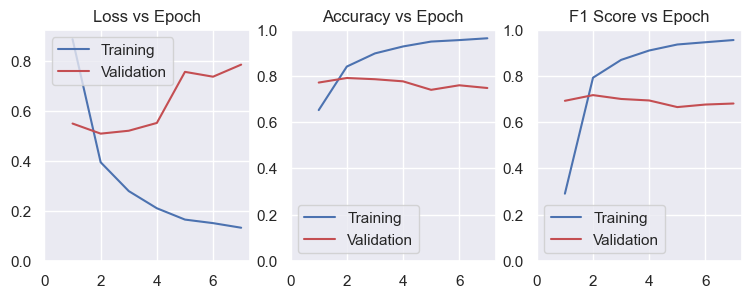

Best validation F1 score (from Batch 2)    was 0.7172793745994568
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.394573  0.840899  0.792655  0.509148      0.791339      0.717279


In [78]:
m1kr= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(32,  kernel_regularizer='l2'),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1kr = runplot(m1kr)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


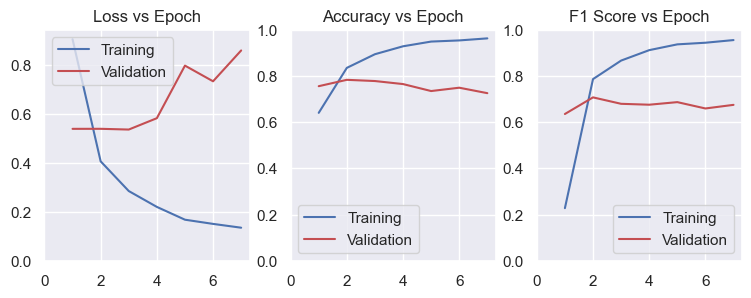

Best validation F1 score (from Batch 2)    was 0.7074897289276123
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.405457  0.835207  0.786563     0.538      0.783465       0.70749


In [81]:
m1krrd= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(32,  kernel_regularizer='l2', recurrent_dropout=0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1krrd = runplot(m1krrd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


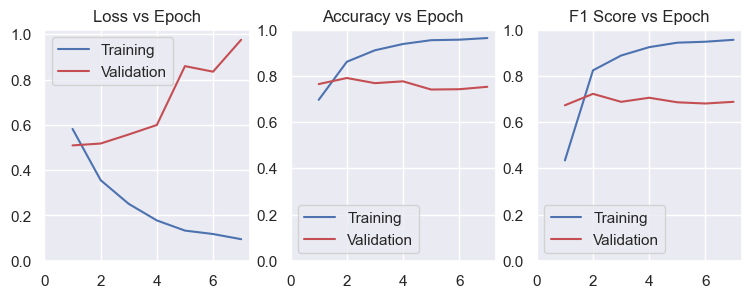

Best validation F1 score (from Batch 2)    was 0.7227630019187927
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.355955  0.861626  0.824524  0.517756      0.791339      0.722763


In [84]:
m1_64= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1_64 = runplot(m1_64)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


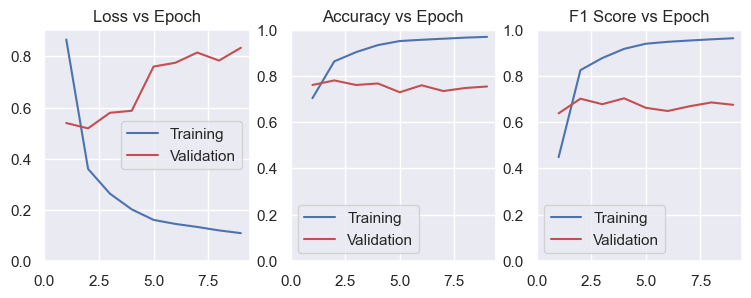

Best validation F1 score (from Batch 4)    was 0.7033767700195312
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.201244  0.933878  0.917527  0.587283      0.767717      0.703377


In [82]:
m1kr_64= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64,  kernel_regularizer='l2'),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1kr_64 = runplot(m1kr_64)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


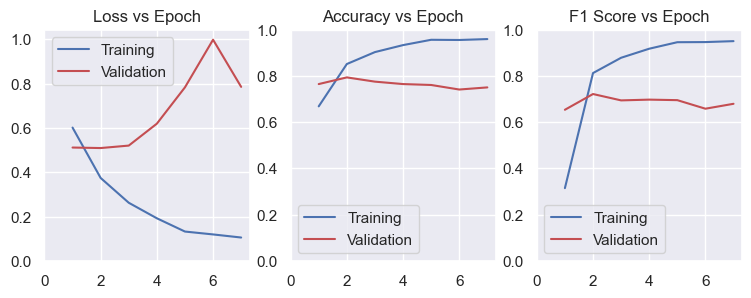

Best validation F1 score (from Batch 2)    was 0.7219874262809753
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.374126  0.851846  0.812696  0.509215      0.793963      0.721987


In [86]:
m1d_64= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64,  dropout=0.05),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1d_64 = runplot(m1d_64)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


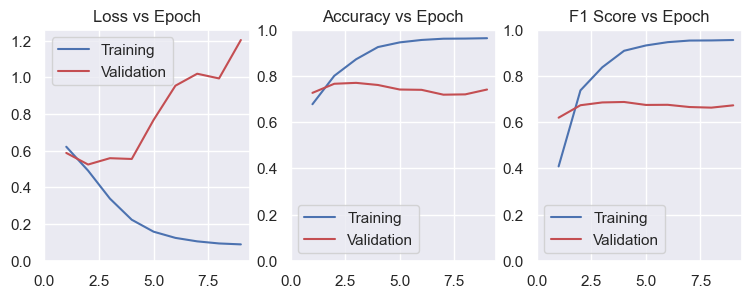

Best validation F1 score (from Batch 4)    was 0.6875657439231873
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.223885  0.925266  0.909193  0.555067      0.761155      0.687566


In [88]:
m1rr_64= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64, recurrent_dropout=0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1rr_64 = runplot(m1rr_64)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


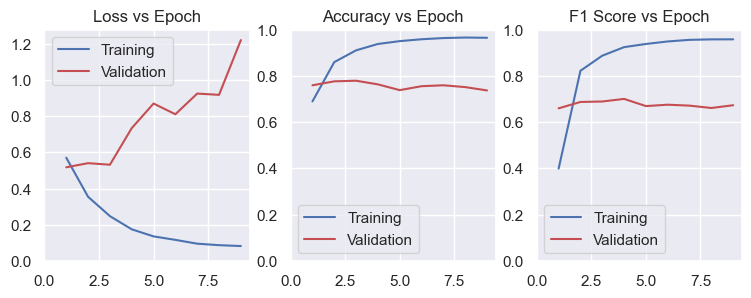

Best validation F1 score (from Batch 4)    was 0.7008758187294006
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.174316  0.938695  0.924954  0.734391       0.76378      0.700876


In [89]:
m1drr_64= Sequential([
     tf.keras.Input(shape=(1,), dtype=tf.string),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64,  dropout=0.05, recurrent_dropout=0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm1drr_64 = runplot(m1drr_64)

#### m2*: Two-Layer LSTM (with and without Regularization<a class="anchor" id="2lstm"></a>

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


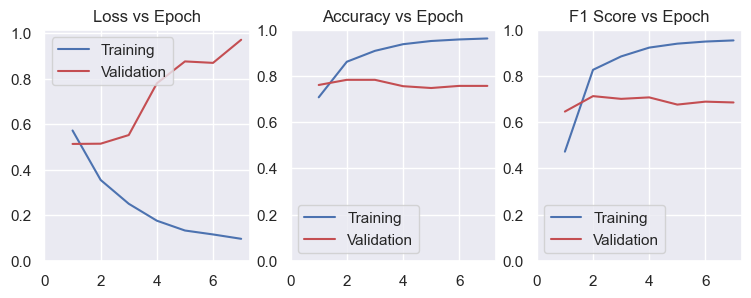

Best validation F1 score (from Batch 2)    was 0.7128944993019104
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.35536  0.861772  0.826715   0.51481      0.783465      0.712894


In [90]:
m2= Sequential([
    tf.keras.Input(shape=(1,), dtype='string'),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hm2 = runplot(m2)

Restoring model weights from the end of the best epoch: 3.
Epoch 8: early stopping


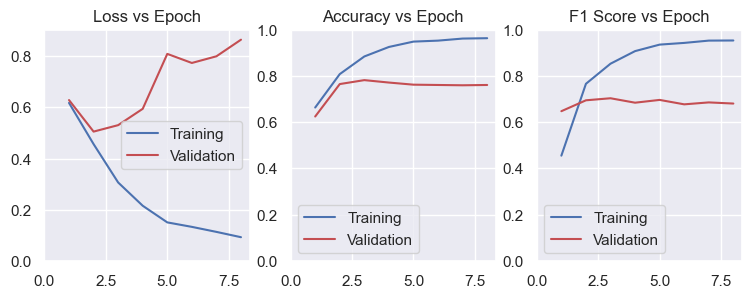

Best validation F1 score (from Batch 3)    was 0.7036788463592529
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
3  0.306282  0.884542  0.853272  0.530418      0.782152      0.703679


In [91]:
m2d= Sequential([
     tf.keras.Input(shape=(1,), dtype='string'),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64, return_sequences=True, dropout = 0.1),
     LSTM(32, dropout = 0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm2d = runplot(m2d)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


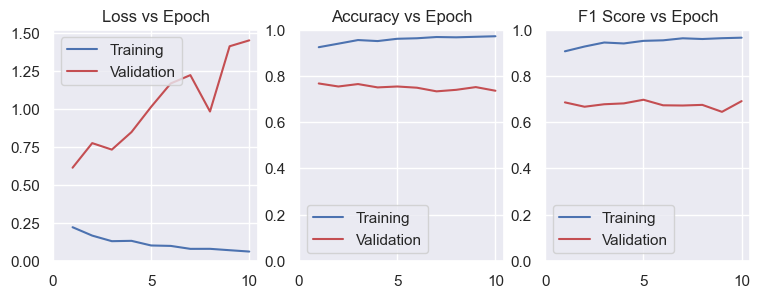

Best validation F1 score (from Batch 5)    was 0.6972505450248718
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.101114  0.961174  0.952172  1.015094      0.754593      0.697251


In [92]:
m2rd= Sequential([
     tf.keras.Input(shape=(1,), dtype='string'),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64, return_sequences=True, recurrent_dropout = 0.1),
     LSTM(32, dropout = 0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm2rd = runplot(m2rd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


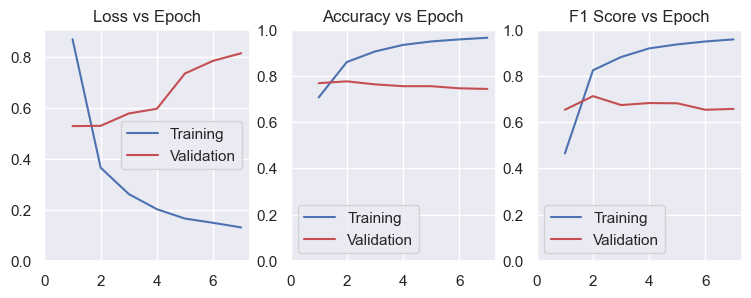

Best validation F1 score (from Batch 2)    was 0.7129275798797607
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.365228  0.860458  0.825087  0.529289      0.776903      0.712928


In [93]:
m2kr= Sequential([
     tf.keras.Input(shape=(1,), dtype='string'),
     Vector_layer,
     Embedding(max_tokens+1, 128),
     LSTM(64, return_sequences=True, kernel_regularizer='l2'),
     LSTM(32, dropout = 0.1),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')])
hm2kr = runplot(m2kr)

> With further trial and error, a two-layer model may yield some incremental gains, but none of the regularization methods has resulted in signifanct f1-score improvements.

#### bm1: Bidirectional 1-Layer LSTM<a class="anchor" id="blstm"></a>

Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping


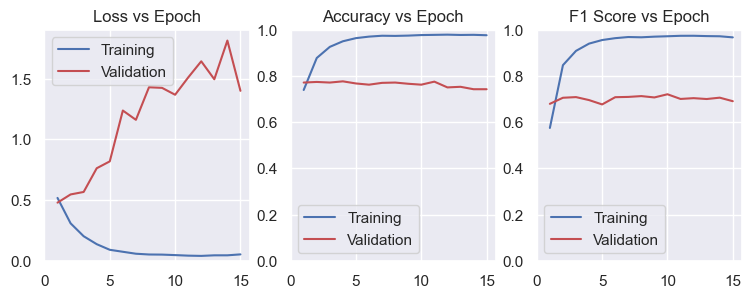

Best validation F1 score (from Batch 10)    was 0.7209436893463135
All stats: 
        loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
10  0.047068   0.97723  0.972092  1.368537      0.762467      0.720944


In [94]:
bm1= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbm1 = runplot(bm1)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


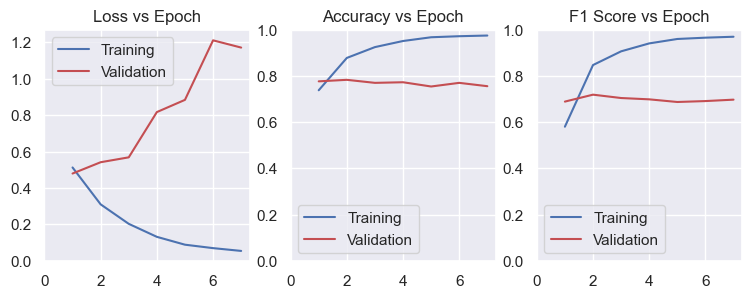

Best validation F1 score (from Batch 2)    was 0.7192347049713135
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.310246  0.878266  0.847405  0.541811      0.783465      0.719235


In [96]:
bm1rd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(LSTM(64, recurrent_dropout=0.05)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbm1rd = runplot(bm1rd)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


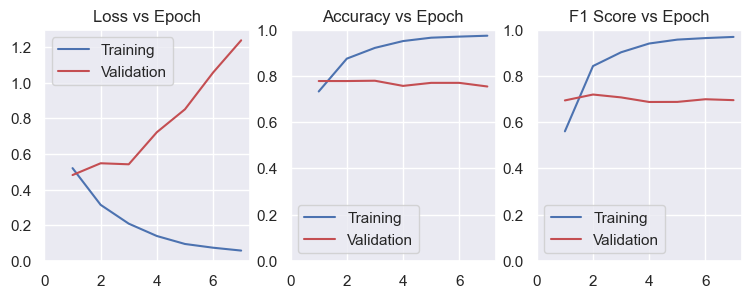

Best validation F1 score (from Batch 2)    was 0.7198082804679871
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.313987  0.875201  0.843089  0.547337      0.778215      0.719808


In [99]:
bm1d= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(LSTM(64, dropout=0.05)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbm1d = runplot(bm1d)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


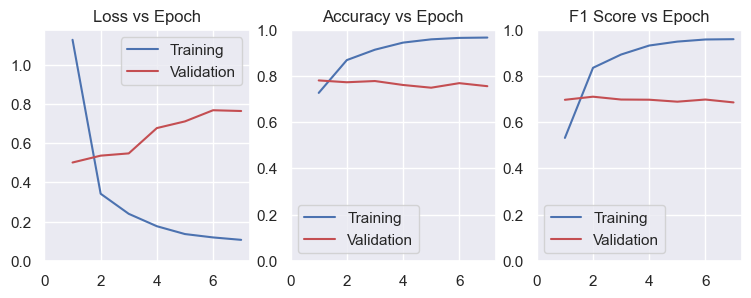

Best validation F1 score (from Batch 2)    was 0.7104213833808899
All stats: 
     loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.3418  0.868924  0.835505  0.535841      0.772966      0.710421


In [98]:
bm1kr= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(LSTM(64, kernel_regularizer='l2')),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hmb1kr = runplot(bm1kr)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


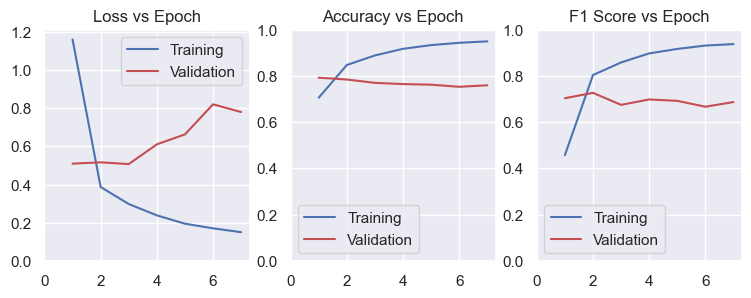

Best validation F1 score (from Batch 2)    was 0.7270877361297607
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.387277  0.847614  0.804284   0.51667      0.784777      0.727088


In [101]:
bm1krdrd= Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    Vector_layer,
    Embedding(max_tokens+1, 128),
    Bidirectional(LSTM(64, kernel_regularizer='l2', dropout=0.3, recurrent_dropout=0.3)),
    #Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')])
hbm1krdrd = runplot(bm1krdrd)

## Models - Strategy 2<a class="anchor" id="model2"></a>

#### Low-Unit Recurrent Models<a class="anchor" id="small"></a>


With 4-unit GRU:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


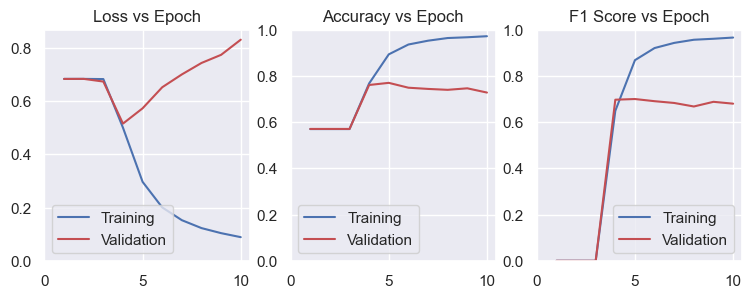

Best validation F1 score (from Batch 5)    was 0.7003354430198669
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.296832  0.893738  0.868607  0.573376      0.770341      0.700335

With 8-unit GRU:

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


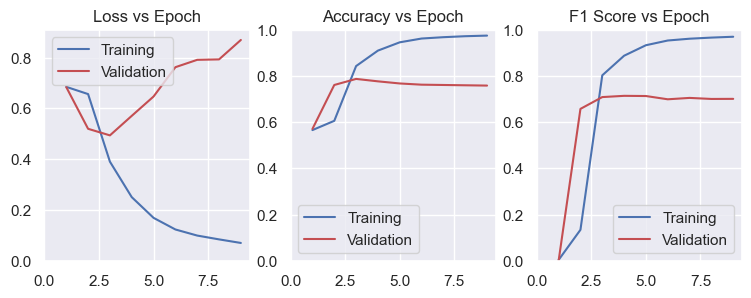

Best validation F1 score (from Batch 4)    was 0.7141630053520203
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.250593   0.90994  0.887755  0.570496      0.776903      0.714163

With 12-unit GRU:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


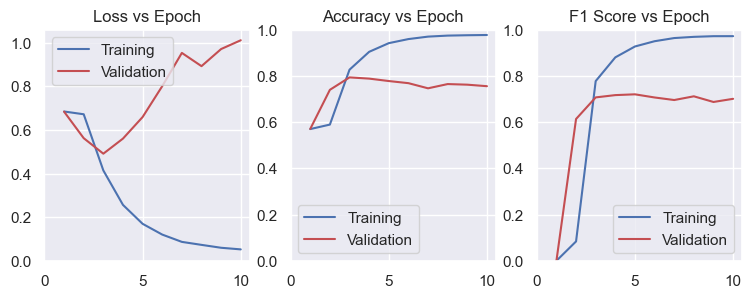

Best validation F1 score (from Batch 5)    was 0.7206991314888
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.169621  0.942198  0.927807  0.659097      0.778215      0.720699

With 16-unit GRU:

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


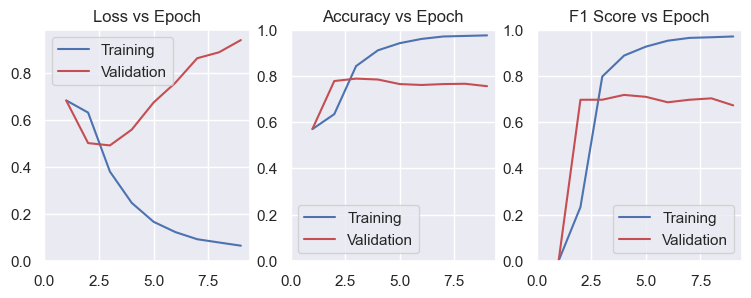

Best validation F1 score (from Batch 4)    was 0.7181527614593506
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.247217  0.911254  0.888505  0.559775      0.784777      0.718153

With 20-unit GRU:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


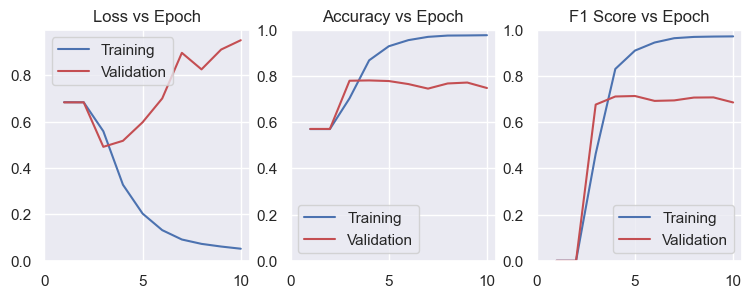

Best validation F1 score (from Batch 5)    was 0.7134080529212952
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.203716   0.92877  0.910038  0.597958      0.778215      0.713408

With 24-unit GRU:

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


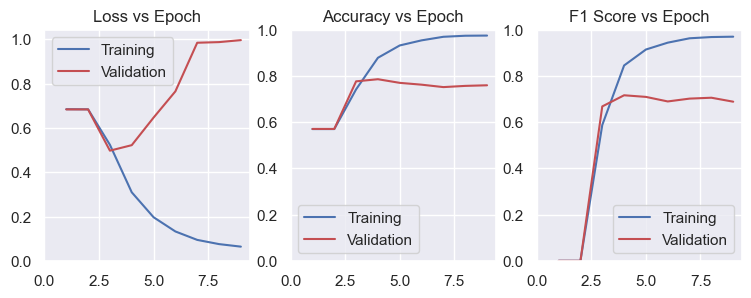

Best validation F1 score (from Batch 4)    was 0.7165912985801697
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
4  0.309395   0.87885   0.84563  0.522256      0.786089      0.716591


In [65]:
for units in range(4,24+1,4):
    print(f'\nWith {units}-unit GRU:\n')
    _ = runplot(Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string),
            Vector_layer,
            Embedding(max_tokens+1, 128),
            GRU(units),
            Dense(1, activation='sigmoid')]))


>>>> With 4-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


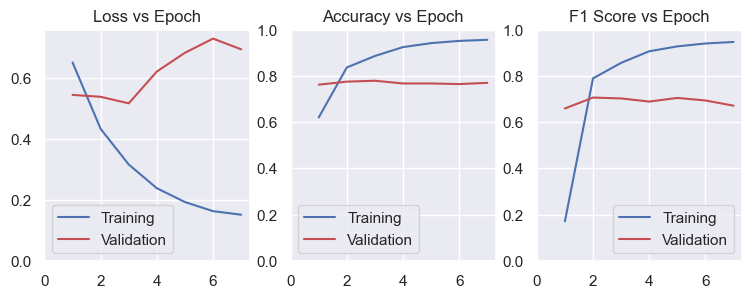

Best validation F1 score (from Batch 2)    was 0.7066338062286377
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.434051  0.836958  0.789686   0.53955      0.775591      0.706634

>>>> With 8-unit LSTM:

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


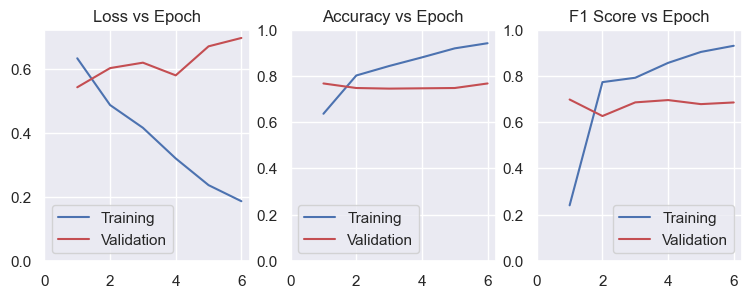

Best validation F1 score (from Batch 1)    was 0.6982553601264954
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
1  0.63302  0.636549  0.240178  0.542446      0.767717      0.698255

>>>> With 12-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


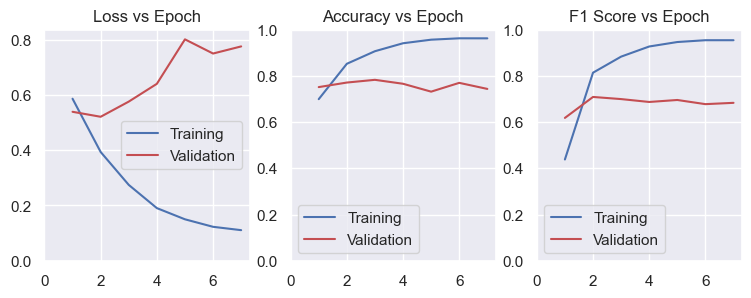

Best validation F1 score (from Batch 2)    was 0.7093114852905273
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.393497  0.852868  0.814324   0.52078      0.771654      0.709311

>>>> With 16-unit LSTM:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


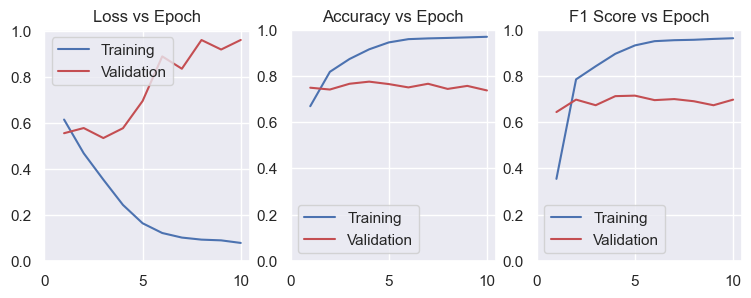

Best validation F1 score (from Batch 5)    was 0.715014636516571
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.163268  0.945409  0.932485  0.695043      0.765092      0.715015

>>>> With 20-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


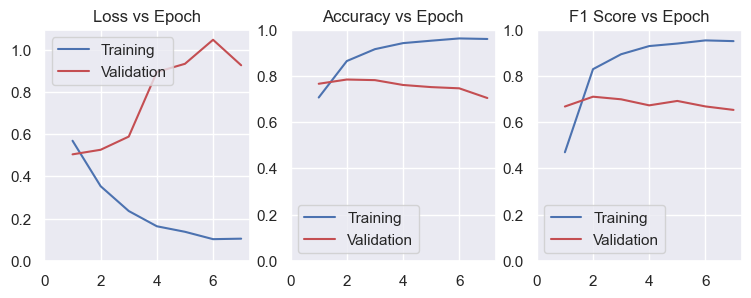

Best validation F1 score (from Batch 2)    was 0.7104365229606628
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.353254  0.864837  0.829616  0.525907      0.784777      0.710437

>>>> With 24-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


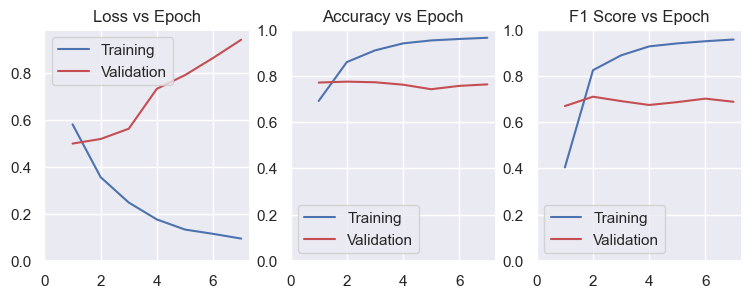

Best validation F1 score (from Batch 2)    was 0.7104324698448181
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.355721  0.860312  0.825211   0.51822      0.775591      0.710432


In [66]:
for units in range(4,24+1,4):
    print(f'\n>>>> With {units}-unit LSTM:\n')
    _ = runplot(Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string),
            Vector_layer,
            Embedding(max_tokens+1, 128),
            LSTM(units),
            Dense(1, activation='sigmoid')]))

#### Low-Unit Recurrent Models with Regularization<a class="anchor" id="small_r"></a>


With 8-unit GRU:

Restoring model weights from the end of the best epoch: 3.
Epoch 8: early stopping


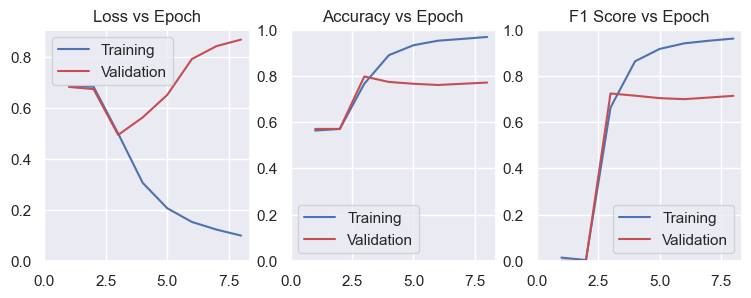

Best validation F1 score (from Batch 3)    was 0.7244572043418884
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
3  0.500288  0.766603  0.663422  0.494896        0.7979      0.724457

With 12-unit GRU:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


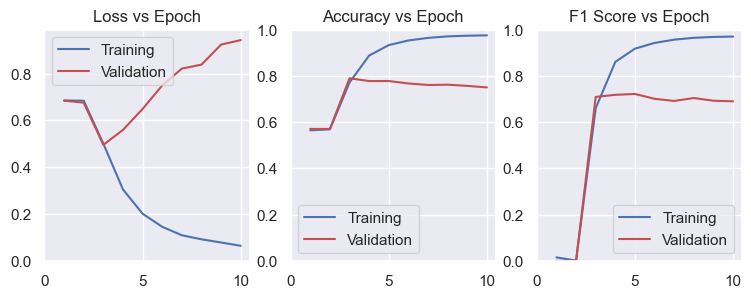

Best validation F1 score (from Batch 5)    was 0.7222716808319092
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.201089  0.933878   0.91834  0.649152      0.778215      0.722272

With 16-unit GRU:

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


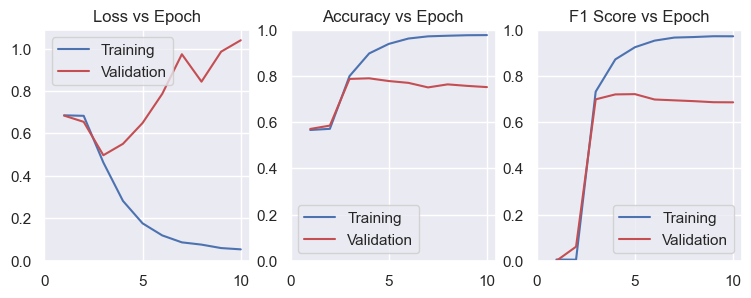

Best validation F1 score (from Batch 5)    was 0.721505343914032
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.176436  0.938987  0.924641  0.649452      0.778215      0.721505


In [73]:
# centered around 12 as that was best result for GRU
for units in range(8,16+1,4):
    print(f'\nWith {units}-unit GRU:\n')
    _ = runplot(Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string),
            Vector_layer,
            Embedding(max_tokens+1, 128),
            GRU(units),
            Dropout(0.3),
            Dense(1, activation='sigmoid')]))


With 12-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


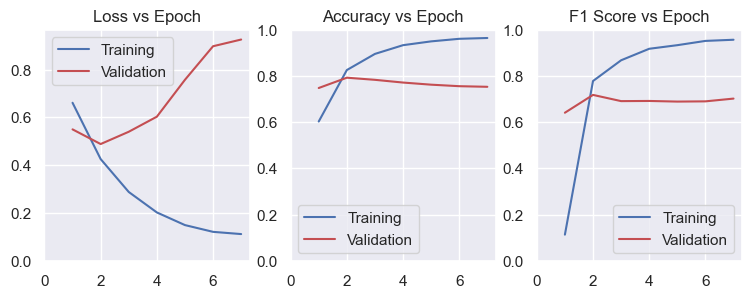

Best validation F1 score (from Batch 2)    was 0.7181870937347412
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.425481  0.825719  0.778261  0.488302      0.792651      0.718187

With 16-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


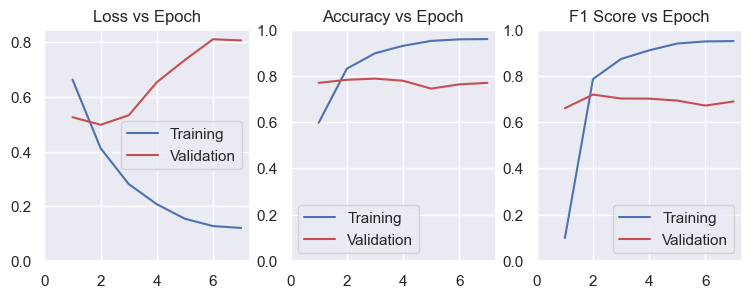

Best validation F1 score (from Batch 2)    was 0.7196049094200134
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.412294  0.831703  0.786906  0.498444      0.783465      0.719605

With 20-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


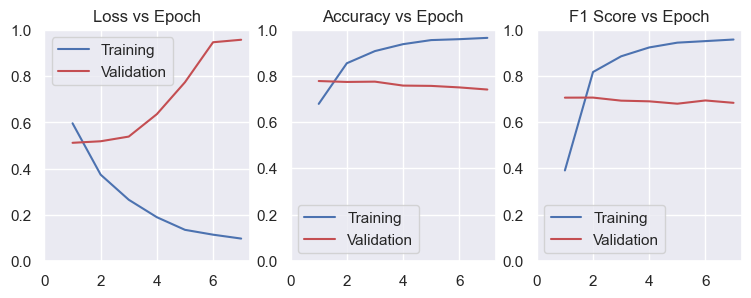

Best validation F1 score (from Batch 2)    was 0.706566333770752
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.373679  0.855204   0.81719   0.51854      0.774278      0.706566


In [76]:
# centered around 16 units, as that was the best result for LSTM
for units in range(12,20+1,4):
    print(f'\nWith {units}-unit LSTM:\n')
    _ = runplot(Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string),
            Vector_layer,
            Embedding(max_tokens+1, 128),
            LSTM(units),
            Dropout(0.3), #add dropout
            Dense(1, activation='sigmoid')]))


With 12-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


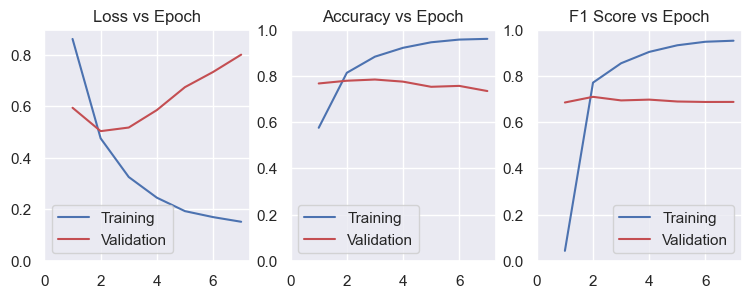

Best validation F1 score (from Batch 2)    was 0.7098557353019714
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.475565  0.813896  0.771284  0.503565      0.779528      0.709856

With 16-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


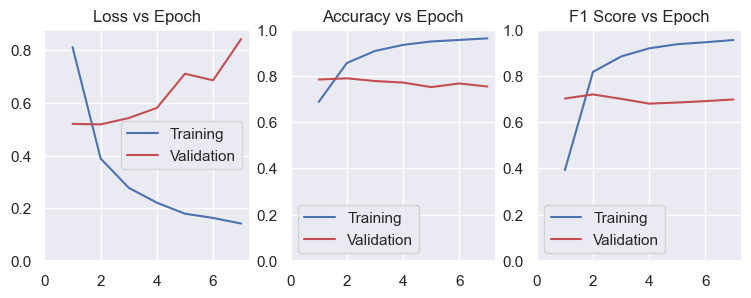

Best validation F1 score (from Batch 2)    was 0.7202573418617249
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.388626  0.856225  0.817976  0.518426      0.790026      0.720257

With 20-unit LSTM:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


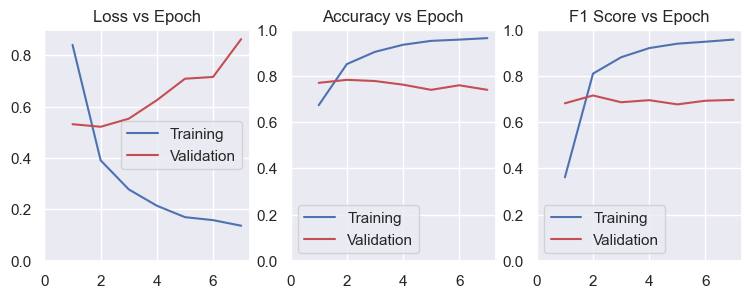

Best validation F1 score (from Batch 2)    was 0.7157140374183655
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
2  0.391021  0.851409  0.810251  0.521758      0.783465      0.715714


In [77]:
# centered around 16 units, as that was the best result for LSTM
for units in range(12,20+1,4):
    print(f'\nWith {units}-unit LSTM:\n')
    _ = runplot(Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string),
            Vector_layer,
            Embedding(max_tokens+1, 128),
            LSTM(units, kernel_regularizer="l2"), #add kernel regularizer
            Dropout(0.3),
            Dense(1, activation='sigmoid')]))

#### Low-Unit Recurrent Models with Strong Regularization<a class="anchor" id="small_rr"></a>

Restoring model weights from the end of the best epoch: 16.
Epoch 21: early stopping


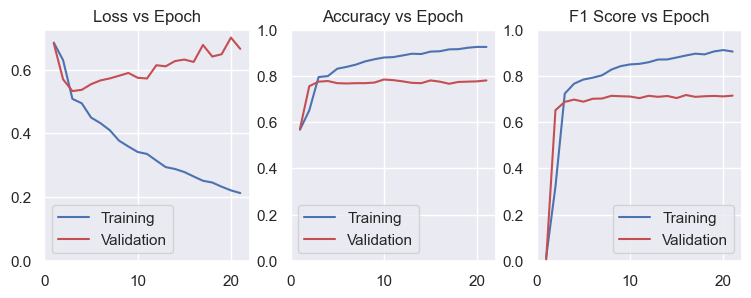

Best validation F1 score (from Batch 16)    was 0.7177114486694336
All stats: 
        loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
16  0.264806  0.907167  0.888814  0.624532      0.775591      0.717711


In [94]:
Low1 = runplot(Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        Vector_layer,
        Embedding(max_tokens+1, 128),
        SpatialDropout1D(0.7),
        LSTM(8, dropout=0.5, recurrent_dropout=0.5),
        Dense(1, activation='sigmoid')]))

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


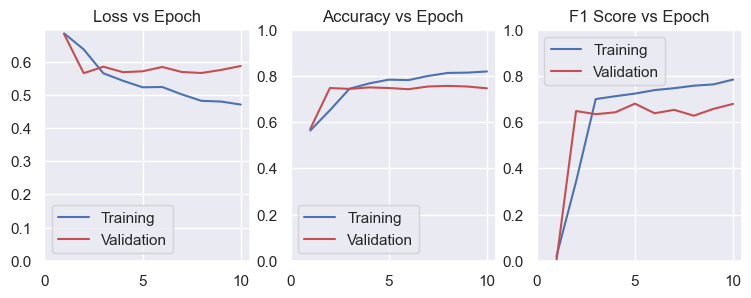

Best validation F1 score (from Batch 5)    was 0.6803910732269287
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
5  0.522512  0.784119  0.723911   0.57072      0.748031      0.680391


In [95]:
Low2 = runplot(Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        Vector_layer,
        Embedding(max_tokens+1, 128),
        SpatialDropout1D(0.8),
        LSTM(8, dropout=0.6, recurrent_dropout=0.6),
        Dense(1, activation='sigmoid')]))

Restoring model weights from the end of the best epoch: 16.
Epoch 21: early stopping


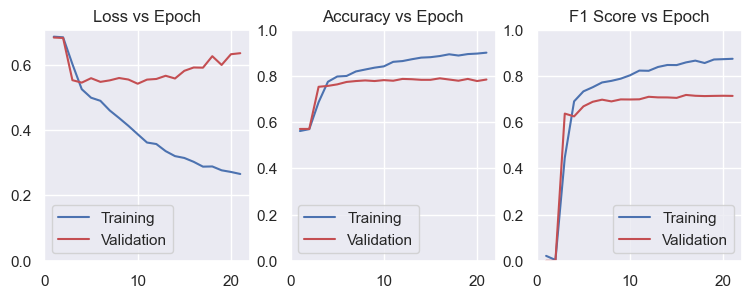

Best validation F1 score (from Batch 16)    was 0.7180101871490479
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
16  0.30304   0.88644  0.858948  0.591714      0.790026       0.71801


In [96]:
Low3 = runplot(Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        Vector_layer,
        Embedding(max_tokens+1, 128),
        SpatialDropout1D(0.8),
        LSTM(12, dropout=0.6, recurrent_dropout=0.6),
        Dense(1, activation='sigmoid')]))

Restoring model weights from the end of the best epoch: 17.
Epoch 22: early stopping


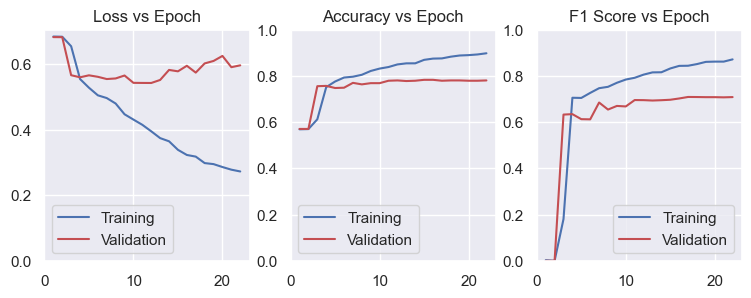

Best validation F1 score (from Batch 17)    was 0.7092902064323425
All stats: 
        loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
17  0.318247  0.876222  0.844424  0.574863      0.779528       0.70929


In [100]:
Low4 = runplot(Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        Vector_layer,
        Embedding(max_tokens+1, 128),
        SpatialDropout1D(0.8),
        LSTM(12, dropout=0.6, recurrent_dropout=0.6),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')]))

Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping


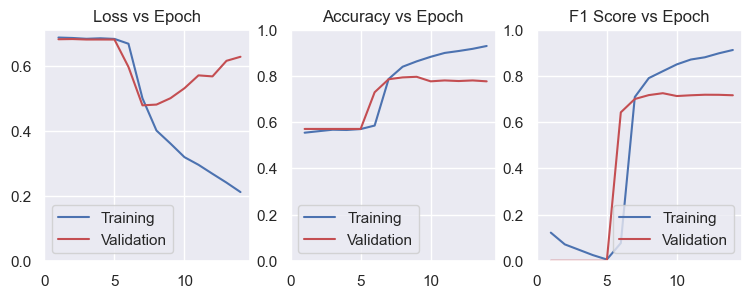

Best validation F1 score (from Batch 9)    was 0.7255533337593079
All stats: 
      loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
9  0.36191  0.863378  0.820812  0.501966      0.796588      0.725553


In [106]:
Low5 = runplot(Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        Vector_layer,
        Embedding(max_tokens+1, 128),
        SpatialDropout1D(0.8),
        GRU(12),
        Dropout(0.6),
        Dense(1, activation='sigmoid')]))

Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


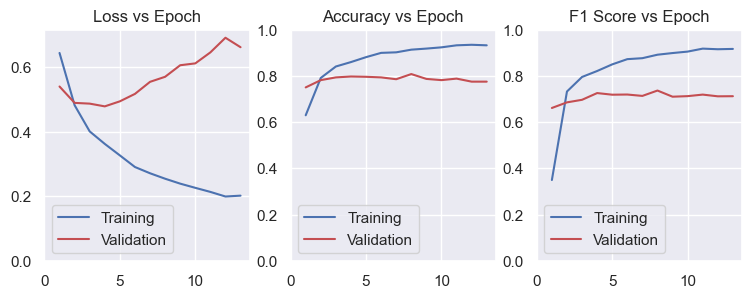

Best validation F1 score (from Batch 8)    was 0.7370312809944153
All stats: 
       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score
8  0.254593  0.914027  0.892179   0.57076      0.808399      0.737031


In [113]:
Low6 = Sequential([
       tf.keras.Input(shape=(1,), dtype=tf.string),
       Vector_layer,
       Embedding(max_tokens+1, 128),
       SpatialDropout1D(0.8),
       Bidirectional(GRU(8)),
       Dropout(0.6),
       Dense(1, activation='sigmoid')])
hLow6 = runplot(Low6)

## Summary of Results<a class="anchor" id="results"></a>

Regardless of regularization and architecture, all models achieved and F1 score of at least 0.69 and, unfortunately, none of the recurrent models outperformed the global pooling model that was used to establish a baseline. 

Using F1-score to evaluate, the top three highest-scoring models were:
1) The base global pooling model (p0): 0.738609
2) A heavily-regularized bidirectional GRU model (Low6): 0.737031
3) A single-layer GRU with recurrent drop-out (g1rd): 0.730253

Each of these model will be used to generate a prediction, and evaluated by Kaggle's leaderboard submission system:

In [131]:
#p0
submdf['target'] = np.round(p0.predict(nmp["tsx"])).astype('int')
submdf.to_csv("submission_p0.csv", index=False)

102/102 [==============================] - 0s 1ms/step


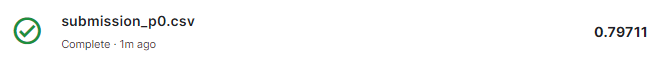

In [138]:
#Low6
submdf['target'] = np.round(Low6.predict(nmp["tsx"])).astype('int')
submdf.to_csv("submission_Low6.csv", index=False)

102/102 [==============================] - 2s 10ms/step


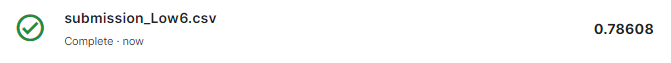

In [141]:
#g1rd
submdf['target'] = np.round(g1rd.predict(nmp["tsx"])).astype('int')
submdf.to_csv("submission_g1rd.csv", index=False)

102/102 [==============================] - 2s 18ms/step


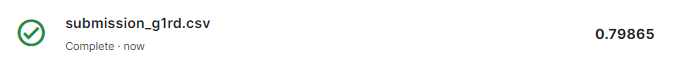

## Conclusion<a class="anchor" id="conclusion"></a>

Parameter tuning didn't yield significant improvement - too little to prove significant general improvement versus specific improvement on the validation set. All three submissions scored close to 80%, with the recurrent-dropout GRU model scoring the best.

To improve the score, I would look at feature selection to see if including the keyword data would improve the result. A larger training set could also really help to prepare the models for new text (as there was evidence of overfitting).

In retrospect, I started with models that were needlessly complex (specifically: including an additional dense layer which turned out not to dramatically improve performance). The recurrent cells didn't dramatically improve with additional units either, so this could have started smaller as well.


## References<a class="anchor" id="references"></a>

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
https://keras.io/api/models/model_training_apis/
https://saturncloud.io/blog/keras-f1-score-metrics-a-comprehensive-guide-for-training-your-model/